<a href="https://colab.research.google.com/github/Jyoti1706/Data-Science-Project/blob/master/cWGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install torch torchvision numpy matplotlib


In [3]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, noise_dim, num_classes, img_channels):
        super(Generator, self).__init__()
        self.label_embed = nn.Embedding(num_classes, noise_dim)
        self.model = nn.Sequential(
            nn.Linear(noise_dim * 2, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, img_channels * 32 * 32),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_embedding = self.label_embed(labels)
        x = torch.cat([noise, label_embedding], dim=1)
        img = self.model(x)
        return img.view(img.size(0), 3, 32, 32)

class Discriminator(nn.Module):
    def __init__(self, img_channels, num_classes):
        super(Discriminator, self).__init__()
        self.label_embed = nn.Embedding(num_classes, img_channels * 32 * 32)
        self.model = nn.Sequential(
            nn.Linear(img_channels * 32 * 32 * 2, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1)
        )

    def forward(self, img, labels):
        label_embedding = self.label_embed(labels)
        x = torch.cat([img.view(img.size(0), -1), label_embedding], dim=1)
        validity = self.model(x)
        return validity


In [4]:
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

dataset = CIFAR10(root="./data", train=True, transform=transform, download=True)

# Filter out only 'automobile' class (class index 1 in CIFAR-10)
automobile_class = 1
filtered_dataset = [(img, label) for img, label in dataset if label == automobile_class]
dataloader = DataLoader(filtered_dataset, batch_size=64, shuffle=True)



100%|██████████| 170498071/170498071 [00:04<00:00, 39939852.43it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [5]:
def wasserstein_loss(y_pred, y_true):
    return torch.mean(y_true * y_pred)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
generator = Generator(noise_dim=100, num_classes=10, img_channels=3).to(device)
discriminator = Discriminator(img_channels=3, num_classes=10).to(device)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002)


cpu


In [6]:
epochs = 150
for epoch in range(epochs):
    for i, (imgs, labels) in enumerate(dataloader):
        real_imgs = imgs.to(device)
        labels = labels.to(device)

        # Train Discriminator
        optimizer_D.zero_grad()

        z = torch.randn(imgs.size(0), 100).to(device)
        fake_imgs = generator(z, labels)

        real_loss = wasserstein_loss(discriminator(real_imgs, labels), torch.ones_like(labels).to(device))
        fake_loss = wasserstein_loss(discriminator(fake_imgs.detach(), labels), -torch.ones_like(labels).to(device))
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()

        gen_imgs = generator(z, labels)
        g_loss = wasserstein_loss(discriminator(gen_imgs, labels), torch.ones_like(labels).to(device))
        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch {epoch}: [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")


Epoch 0: [D loss: -32.267215728759766] [G loss: 1.209732174873352]
Epoch 1: [D loss: 573.005859375] [G loss: -1388.228271484375]
Epoch 2: [D loss: -4262.0478515625] [G loss: 3216.36376953125]
Epoch 3: [D loss: 2646.8525390625] [G loss: -6477.85498046875]
Epoch 4: [D loss: -7312.34375] [G loss: -1364.478515625]
Epoch 5: [D loss: -50091.45703125] [G loss: -48.523067474365234]
Epoch 6: [D loss: 71500.8828125] [G loss: -172244.515625]
Epoch 7: [D loss: -74251.1875] [G loss: 37938.5625]
Epoch 8: [D loss: -31365.54296875] [G loss: -9377.8935546875]
Epoch 9: [D loss: -127809.921875] [G loss: 92798.84375]
Epoch 10: [D loss: -373776.6875] [G loss: 203468.6875]
Epoch 11: [D loss: -903492.75] [G loss: 470678.96875]
Epoch 12: [D loss: -1773181.75] [G loss: 950367.625]
Epoch 13: [D loss: -3151205.25] [G loss: 1737230.0]
Epoch 14: [D loss: -5145647.5] [G loss: 2892986.25]
Epoch 15: [D loss: -7580633.0] [G loss: 4410735.5]
Epoch 16: [D loss: 3593028.5] [G loss: -7776628.5]
Epoch 17: [D loss: 2633296.

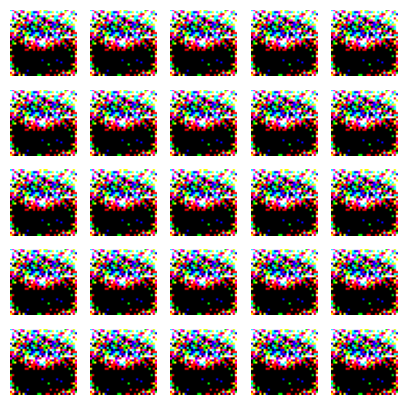

In [7]:
import matplotlib.pyplot as plt

def generate_and_save_images(generator, num_images=25, noise_dim=100, class_label=1):
    z = torch.randn(num_images, noise_dim).to(device)
    labels = torch.full((num_images,), class_label, dtype=torch.long).to(device)
    gen_imgs = generator(z, labels).cpu().detach()

    fig, axs = plt.subplots(5, 5, figsize=(5, 5))
    for i in range(5):
        for j in range(5):
            axs[i, j].imshow(gen_imgs[i * 5 + j].permute(1, 2, 0) * 0.5 + 0.5)
            axs[i, j].axis('off')
    plt.show()

generate_and_save_images(generator, 25)


In [ ]:
from torchvision.models import inception_v3
from torch.autograd import Variable
from scipy.stats import entropy

inception_model = inception_v3(pretrained=True).to(device)
inception_model.eval()

def inception_score(images, inception_model, num_splits=10):
    # Resize images to Inception expected size
    images_resized = torch.nn.functional.interpolate(images, size=(299, 299))
    preds = inception_model(images_resized).detach().cpu().numpy()
    split_scores = []

    for k in range(num_splits):
        part = preds[k * (images.shape[0] // num_splits): (k + 1) * (images.shape[0] // num_splits), :]
        p_y = np.mean(part, axis=0)
        scores = [entropy(p_y, p) for p in part]
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)

# Compute IS for generated images
gen_imgs = generator(torch.randn(5000, 100).to(device), torch.full((5000,), 1, dtype=torch.long).to(device))
IS, IS_std = inception_score(gen_imgs, inception_model)
print(f"Inception Score: {IS} ± {IS_std}")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 188MB/s] 


In [ ]:
from pytorch_fid import fid_score

# Compute FID between real and generated automobile images
real_images_path = "./data/real_automobiles"
generated_images_path = "./data/generated_automobiles"

fid_value = fid_score.calculate_fid_given_paths([real_images_path, generated_images_path], batch_size=50, device=device, dims=2048)
print(f"FID: {fid_value}")


In [ ]:
from pytorch_fid import fid_score

# Compute FID between real and generated automobile images
real_images_path = "./data/real_automobiles"
generated_images_path = "./data/generated_automobiles"

fid_value = fid_score.calculate_fid_given_paths([real_images_path, generated_images_path], batch_size=50, device=device, dims=2048)
print(f"FID: {fid_value}")
